In [491]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy.ndimage.morphology import binary_erosion, binary_dilation, grey_dilation
from itertools import product

C:\Users\asus_\AppData\Local\Temp\ipykernel_15364\453063684.py:8: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation, grey_dilation
C:\Users\asus_\AppData\Local\Temp\ipykernel_15364\453063684.py:8: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation, grey_dilation
C:\Users\asus_\AppData\Local\Temp\ipykernel_15364\453063684.py:8: DeprecationWarning: Please use `grey_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation, grey_dilation


In [165]:
def load_dataset(set_name, labels=None, max_per_label=None):
    np.random.seed(0)
    dataset_path = '../datasets/raw/{}'.format(set_name)
    print('Loading dataset from `{}`'.format(dataset_path))
    
    images, metadata = [], []
    if labels is None:
        labels = os.listdir(dataset_path)
    elif isinstance(labels, str):
        labels = [labels]
    elif not isinstance(labels, list):
        raise ValueError('labels must be a list of strings')

    for label in labels:
        label_path = f'{dataset_path}/{label}'
        fnames = os.listdir(label_path)
        if max_per_label is not None:
            count = min(max_per_label, len(fnames))
            fnames = np.random.choice(fnames, count, replace=False)
        
        df = []
        print('> Loading', label, 'class')
        for fname in tqdm(fnames):
            img_path = f'{label_path}/{fname}'
            data_dict = {'image_path': img_path, 'label': label}
            image = np.array(Image.open(img_path))

            df.append(data_dict)
            images.append(image)

        df = pd.DataFrame(df)
        metadata.append(df)

    metadata = pd.concat(metadata).reset_index(drop=True)
    images = np.array(images)
    return images, metadata

In [169]:
train_images, train_metadata = load_dataset(set_name='Train', max_per_label=100)
test_images, test_metadata = load_dataset(set_name='TestA', max_per_label=50)

Loading dataset from `../datasets/raw/Train`
> Loading Basophil class


100%|██████████| 100/100 [00:00<00:00, 298.41it/s]


> Loading Eosinophil class


100%|██████████| 100/100 [00:00<00:00, 376.26it/s]


> Loading Lymphocyte class


100%|██████████| 100/100 [00:00<00:00, 394.19it/s]


> Loading Monocyte class


100%|██████████| 100/100 [00:00<00:00, 404.37it/s]


> Loading Neutrophil class


100%|██████████| 100/100 [00:00<00:00, 329.37it/s]


Loading dataset from `../datasets/raw/TestA`
> Loading Basophil class


100%|██████████| 50/50 [00:00<00:00, 340.74it/s]


> Loading Eosinophil class


100%|██████████| 50/50 [00:00<00:00, 404.66it/s]


> Loading Lymphocyte class


100%|██████████| 50/50 [00:00<00:00, 427.19it/s]


> Loading Monocyte class


100%|██████████| 50/50 [00:00<00:00, 429.69it/s]


> Loading Neutrophil class


100%|██████████| 50/50 [00:00<00:00, 432.93it/s]


In [170]:
train_metadata[:500]

,image_path,label
0,../datasets/raw/Train/Basophil/20190604_111208...,Basophil
1,../datasets/raw/Train/Basophil/20190526_170312...,Basophil
2,../datasets/raw/Train/Basophil/20190527_114937...,Basophil
3,../datasets/raw/Train/Basophil/20190531_121357...,Basophil
4,../datasets/raw/Train/Basophil/20190531_114008...,Basophil
...,...,...
495,../datasets/raw/Train/Neutrophil/95-8-12-2_19_...,Neutrophil
496,../datasets/raw/Train/Neutrophil/95-8-24-1_157...,Neutrophil
497,../datasets/raw/Train/Neutrophil/95-8-1-1_656_...,Neutrophil
498,../datasets/raw/Train/Neutrophil/95-5-10-1_104...,Neutrophil


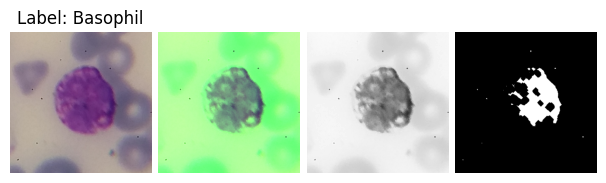

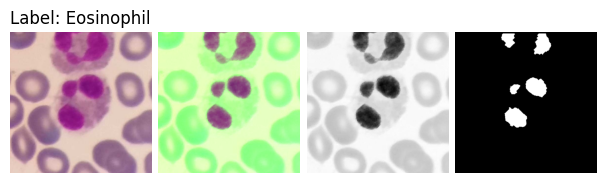

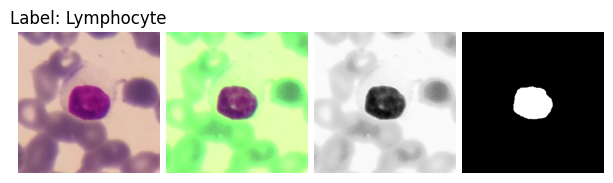

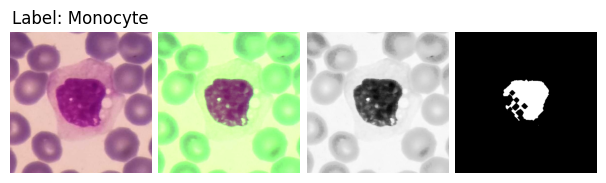

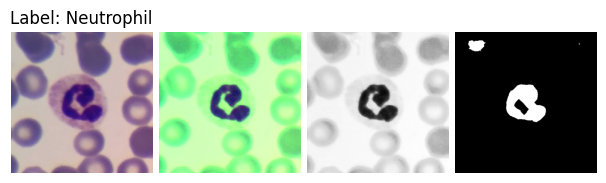

In [443]:
def rgb_to_ggb(image_):
    image = image_.copy()
    g = image[:, :, 1]
    g = np.minimum(255, g * 3.0)
    image[:, :, 1] = g
    return image

def rgb_to_gray(image_):
    image = image_.copy()
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
    return image

def gray_to_binary(image_, th=120):
    image = image_.copy()
    image = (image < th) * 255
    return image

indices = np.array([0, 100, 200, 300, 400]) + 10

for idx in indices:
    fig, ax = plt.subplots(1, 4, figsize=(6, 6), sharey=True)

    image = train_images[idx]
    ggb = rgb_to_ggb(image)

    # for c in [0, 2]:
    #     hist = ggb.reshape((-1, 3))[:, c]
    #     ma, mi = np.percentile(hist, 99), np.percentile(hist, 1)
    #     d = ggb[:, :, c]
    #     d = (d - mi) / (ma - mi)
    #     d = d.astype(int)
    #     ggb[:, :, c] = d

    # ggb[:, :, 0] = (ggb[:, :, 0] * 0.7).astype(int)
    # ggb[:, :, 2] = (ggb[:, :, 2] * 0.7).astype(int)
    gray = rgb_to_gray(ggb)
    # gray = grey_dilation(gray, structure=np.ones((3, 3)))
    # th = np.percentile(gray, 5)
    # gray[gray < th] = (gray[gray < th] * 0.5).astype(int)
    # gray[gray >= th] = (gray[gray >= th] * 1.5).astype(int)
    th = np.percentile(gray, 5)
    binary = gray_to_binary(gray, th=th)
    binary = binary_dilation(binary, iterations=10)
    binary = binary_erosion(binary, iterations=10)

    ax[0].imshow(image)
    ax[1].imshow(ggb)
    ax[2].imshow(gray, cmap='gray')
    ax[3].imshow(binary, cmap='gray')

    for a in ax:
        a.axis('off')

    ax[0].set_title('Label: {}'.format(train_metadata.iloc[idx]['label']))
    fig.tight_layout(pad=0.5)
    plt.show()

In [450]:
def preprocess(image_):
    image = image_.copy()
    ggb = rgb_to_ggb(image)
    gray = rgb_to_gray(ggb)
    th = np.percentile(gray, 5)
    binary = gray_to_binary(gray, th=th)
    binary = binary_dilation(binary, iterations=10)
    binary = binary_erosion(binary, iterations=10)
    return (binary * 1).astype(np.uint8)

def bulk_preprocess(images):
    return np.array([preprocess(img) for img in tqdm(images)])

In [451]:
prep_train_images = bulk_preprocess(train_images)
prep_test_images = bulk_preprocess(test_images)

100%|██████████| 250/250 [00:04<00:00, 54.29it/s]


In [485]:
from skimage.feature import graycomatrix

distances = [1, 2, 3]
angles = [0, np.pi / 6, np.pi / 3, np.pi / 2, 2 * np.pi / 3, 5 * np.pi / 6, np.pi, 7 * np.pi / 6, 4 * np.pi / 3, 3 * np.pi / 2, 5 * np.pi / 3, 11 * np.pi / 6]

def get_glcm(image, distances=distances, angles=angles):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=2, normed=True)
    return glcm

In [507]:
def extract_glcm_features(images):
    features = []
    for image in tqdm(images):
        glcm = get_glcm(image).ravel()
        features.append(glcm)
    return np.array(features)

In [508]:
train_features = extract_glcm_features(prep_train_images)
test_features = extract_glcm_features(prep_test_images)

100%|██████████| 250/250 [00:04<00:00, 50.85it/s]


In [511]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_metadata['label'])
train_labels = le.transform(train_metadata['label'])
test_labels = le.transform(test_metadata['label'])

In [512]:
feature_names = list(product(
    ['f0', 'f1', 'f2', 'f3'],
    ['d' + str(i) for i in range(len(distances))],
    ['t' + str(i) for i in range(len(angles))],
))
feature_names = ['_'.join(f) for f in feature_names]

train_features = pd.DataFrame(train_features, columns=feature_names)
test_features = pd.DataFrame(test_features, columns=feature_names)

In [515]:
train_features.to_csv('../datasets/clean/train_features.csv', index=False)
test_features.to_csv('../datasets/clean/test_features.csv', index=False)
train_metadata.to_csv('../datasets/clean/train_metadata.csv', index=False)
test_metadata.to_csv('../datasets/clean/test_metadata.csv', index=False)

In [545]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

xgb = XGBClassifier()
xgb.fit(train_features, train_labels)
y_pred = xgb.predict(test_features)
print(classification_report(test_labels, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9184    0.9000    0.9091        50
           1     0.4565    0.4200    0.4375        50
           2     0.5918    0.5800    0.5859        50
           3     0.6250    0.7000    0.6604        50
           4     0.5600    0.5600    0.5600        50

    accuracy                         0.6320       250
   macro avg     0.6303    0.6320    0.6306       250
weighted avg     0.6303    0.6320    0.6306       250



In [550]:
params_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.3],
    'n_estimators': [100, 300]
}

xgb = XGBClassifier()
grid = GridSearchCV(xgb, params_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=1)
grid.fit(train_features, train_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   2.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   2.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   3.0s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=6, n_est

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.3], 'max_depth': [3, 6],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=2)

In [551]:
print(grid.best_params_, grid.best_score_)
better_xgb = XGBClassifier(**grid.best_params_)
better_xgb.fit(train_features, train_labels)
y_pred = better_xgb.predict(test_features)
print(classification_report(test_labels, y_pred, digits=4))

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100} 0.658
              precision    recall  f1-score   support

           0     0.9787    0.9200    0.9485        50
           1     0.3958    0.3800    0.3878        50
           2     0.6364    0.5600    0.5957        50
           3     0.6610    0.7800    0.7156        50
           4     0.4808    0.5000    0.4902        50

    accuracy                         0.6280       250
   macro avg     0.6305    0.6280    0.6275       250
weighted avg     0.6305    0.6280    0.6275       250



In [553]:
params_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, params_grid, cv=5, scoring='accuracy', n_jobs=1)
grid.fit(train_features, train_labels)

print(grid.best_params_, grid.best_score_)
better_knn = KNeighborsClassifier(**grid.best_params_)
better_knn.fit(train_features, train_labels)
y_pred = better_knn.predict(test_features)
print(classification_report(test_labels, y_pred, digits=4))

{'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'distance'} 0.66
              precision    recall  f1-score   support

           0     0.9583    0.9200    0.9388        50
           1     0.4898    0.4800    0.4848        50
           2     0.7368    0.5600    0.6364        50
           3     0.7273    0.8000    0.7619        50
           4     0.4833    0.5800    0.5273        50

    accuracy                         0.6680       250
   macro avg     0.6791    0.6680    0.6698       250
weighted avg     0.6791    0.6680    0.6698       250

